In [11]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

try: import timm
except ModuleNotFoundError:
    !pip install -Uq "timm>=0.6.2.dev0"

try: import tensorflow
except ModuleNotFoundError:
    !pip install -Uq tensorflow

try: import torcheval
except ModuleNotFoundError:
    !pip install -Uq torcheval

In [12]:
from fastkaggle import *

In [13]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not iskaggle and not cred_path.exists():
    creds = ''
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [14]:
comp = 'tpu-getting-started'

path = setup_comp(comp, install='fastai tensorflow "timm>=0.6.2.dev0"')
classes = ["pink primrose","hard-leaved pocket orchid","canterbury bells","sweet pea","wild geranium","tiger lily","moon orchid","bird of paradise","monkshood","globe thistle","snapdragon","colt's foot","king protea","spear thistle","yellow iris","globe-flower","purple coneflower","peruvian lily","balloon flower","giant white arum lily","fire lily","pincushion flower","fritillary","red ginger","grape hyacinth","corn poppy","prince of wales feathers","stemless gentian","artichoke","sweet william","carnation","garden phlox","love in the mist","cosmos","alpine sea holly","ruby-lipped cattleya","cape flower","great masterwort","siam tulip","lenten rose","barberton daisy","daffodil","sword lily","poinsettia","bolero deep blue","wallflower","marigold","buttercup","daisy","common dandelion","petunia","wild pansy","primula","sunflower","lilac hibiscus","bishop of llandaff","gaura","geranium","orange dahlia","pink-yellow dahlia","cautleya spicata","japanese anemone","black-eyed susan","silverbush","californian poppy","osteospermum","spring crocus","iris","windflower","tree poppy","gazania","azalea","water lily","rose","thorn apple","morning glory","passion flower","lotus","toad lily","anthurium","frangipani","clematis","hibiscus","columbine","desert-rose","tree mallow","magnolia","cyclamen ","watercress","canna lily","hippeastrum ","bee balm","pink quill","foxglove","bougainvillea","camellia","mallow","mexican petunia","bromelia","blanket flower","trumpet creeper","blackberry lily","common tulip","wild rose"]

In [15]:
path

Path('tpu-getting-started')

In [16]:
import timm
import functools
import itertools
from fastai.vision.all import *

path.ls()

(#5) [Path('tpu-getting-started/sample_submission.csv'),Path('tpu-getting-started/tfrecords-jpeg-224x224'),Path('tpu-getting-started/tfrecords-jpeg-192x192'),Path('tpu-getting-started/tfrecords-jpeg-512x512'),Path('tpu-getting-started/tfrecords-jpeg-331x331')]

In [18]:
data_paths = list(filter(lambda x: str(x) != "tpu-getting-started/sample_submission.csv", path.ls()))
data_paths = [path/'tfrecords-jpeg-512x512']
data_paths = functools.reduce(lambda acc, path: list(itertools.chain(acc, (path/'train').ls(), (path/'val').ls())), data_paths, [])

In [19]:
import tensorflow as tf

# https://www.tensorflow.org/tutorials/load_data/tfrecord#reading_a_tfrecord_file_in_python
def load_tfrecs(data_paths, is_test=False):
    data = []
    raw_dataset = tf.data.TFRecordDataset(data_paths)

    for record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(record.numpy())
        datum = [
            None if is_test else example.features.feature['class'].int64_list.value[0],
            example.features.feature['image'].bytes_list.value[0],
            example.features.feature['id'].bytes_list.value[0],
        ]
        data.append(datum)

    return data

data = load_tfrecs(data_paths)

len(data)

16465

(512, 512)


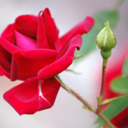

In [20]:
img = PILImage.create(data[0][1])
print(img.size)
img.to_thumb(128)

In [21]:
from fastcore.parallel import *

def f(o): return PILImage.create(o[1]).size
sizes = parallel(f, data, n_workers=8)
pd.Series(sizes).value_counts()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


,count
"(512, 512)",16465


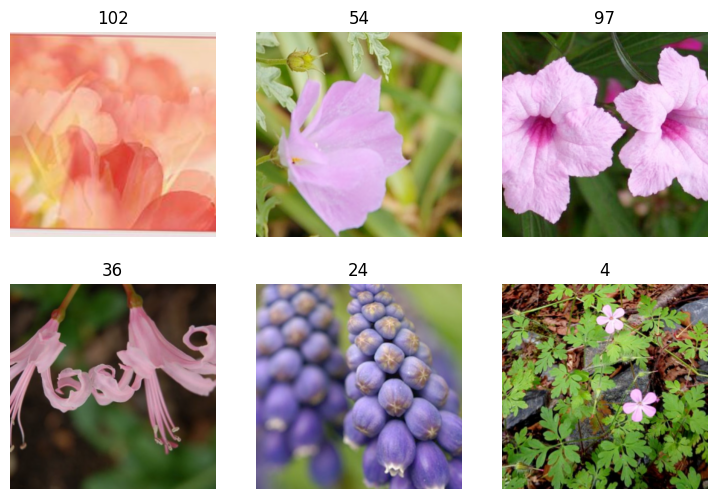

In [23]:
def get_items(data, *args, **kwargs): return data

get_x = lambda entry: PILImage.create(io.BytesIO(entry[1]))
get_y = lambda entry: entry[0]

block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_items,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=IndexSplitter(range(12753, len(data))),
                  item_tfms=[],
                  batch_tfms=[*aug_transforms(size=341, min_scale=0.75)])

dls = block.dataloaders(data, bs=64)
dls.show_batch(max_n=6)

In [24]:
from torcheval.metrics.functional import multiclass_f1_score

learn = vision_learner(dls, 'convnext_small_in22k', metrics=multiclass_f1_score, path='.').to_fp16()

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=0.0014454397605732083, slide=0.0030199517495930195)

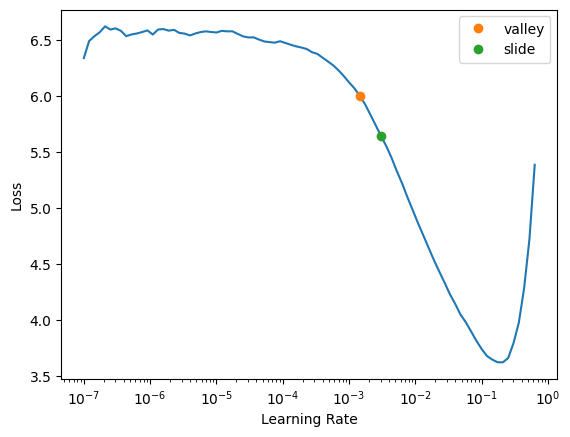

In [25]:
learn.lr_find(suggest_funcs=(valley, slide))

In [26]:
learn.fine_tune(5, 0.001)

epoch,train_loss,valid_loss,multiclass_f1_score,time
0,1.048230,0.208036,0.956627,03:29


epoch,train_loss,valid_loss,multiclass_f1_score,time
0,0.232800,0.154980,0.964978,04:27
1,0.181752,0.131279,0.973599,04:27
2,0.107527,0.126375,0.976293,04:27
3,0.058733,0.125386,0.976832,04:28
4,0.041668,0.124720,0.976024,04:27


In [27]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)
error_rate(preds, targs)

TensorBase(0.0240)

In [28]:
tta_preds,_ = learn.tta(dl=valid)
error_rate(tta_preds, targs)

TensorBase(0.0218)

In [29]:
sample_submission = pd.read_csv(path/'sample_submission.csv')
sample_submission

,id,label
0,b48c962e0,0
1,a13d3dfa4,0
2,94269c190,0
3,bcb18c6e4,0
4,d15a4d94c,0
...,...,...
7377,3744d58d1,0
7378,075602d66,0
7379,b4d954bdc,0
7380,f84335116,0


In [44]:
# torch.save(learn.model.state_dict(), '02.pth')
# from google.colab import files
# files.download('02.pth')
# learn = vision_learner(dls, 'convnext_small_in22k', metrics=multiclass_f1_score, path='.').to_fp16()
# learn.model.load_state_dict(torch.load('01.pth'))

# learn = vision_learner(dls, 'convnext_small_in22k', metrics=multiclass_f1_score, path='.').to_fp16()
# learn.model.load_state_dict(torch.load('01.pth', map_location=torch.device('cpu')))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
test_paths = [(path/'tfrecords-jpeg-512x512/test').ls()]
test_data = load_tfrecs(test_paths, is_test=True)
len(test_data)

7382

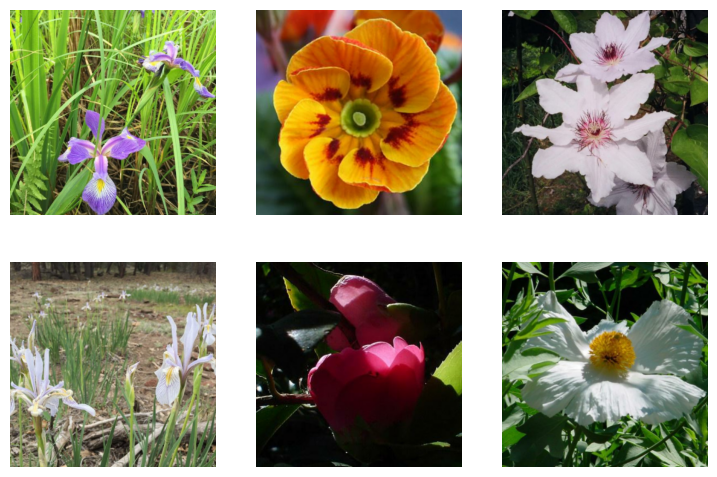

In [32]:
test_dataloader = dls.test_dl(test_data)
test_dataloader.show_batch(max_n=6)

In [35]:
preds,_ = learn.tta(dl=test_dataloader)
idxs = preds.argmax(dim=1)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [36]:
idxs

tensor([ 67,  52,  81,  ...,  53,  41, 102])

In [37]:
learn.dls.vocab

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]

In [ ]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="label")
results

In [ ]:
ids = pd.Series([datum[2].decode('utf-8') for datum in test_data], name="id")
ids

In [40]:
submission = pd.DataFrame({'id': ids, 'label': results})
submission.to_csv('submission.csv', header=True, index=False)

In [41]:
!head submission.csv

id,label
252d840db,67
dfd946ac8,52
0c3ae4377,81
a31f90373,67
0bf251179,95
2dd56f346,69
d5320553f,68
e45a81eb4,4
6074e6638,43


In [42]:
# if not iskaggle:
#    from kaggle import api
#    api.competition_submit_cli('submission.csv', 'petals-to-the-metal-01', comp)

In [ ]:
if not iskaggle:
    push_notebook('alexchalk', 'petals-to-the-metal-submission-02',
                  title='Petals to the Metal Submission 02',
                  file='02.ipynb',
                  competition=comp, private=True, gpu=False)

Kernel version 17 successfully pushed.  Please check progress at https://www.kaggle.com/code/alexchalk/petals-to-the-metal-submission-01
